In [ ]:
# To create a smaller training dataset and to create a test dataset

# import pandas as pd

# input_file = 'Covid Data.csv'
# df = pd.read_csv(input_file)
# df_selected = df.head(55000)

# output_file = 'Covid Test Data 55k.csv'
# df_selected.to_csv(output_file, index=False)

# print(f"Saved {len(df_selected)} rows to {output_file}.")


# df = pd.read_csv(input_file)
# df_selected = df.tail(20000)

# output_file = 'Covid_Test_Data_20k.csv'
# df_selected.to_csv(output_file, index=False)

# print(f"Saved {len(df_selected)} rows to {output_file}.")

In [21]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

data = pd.read_csv('/content/Covid Data 55k.csv')

data = data.drop(columns = ['DATE_DIED'])
data = data.dropna()
X = data.drop(columns = ['CLASIFFICATION_FINAL'])  # Features
y = data['CLASIFFICATION_FINAL']  # Labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

print("Data pre-processing done")

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(128, 64)
        # self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(64, output_dim)
        # self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim, lr = 0.0001, gamma = 0.95, epsilon = 1.0, epsilon_decay = 0.9995, min_epsilon = 0.001):
        self.model = DQN(input_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, output_dim)
        state = torch.tensor(state, dtype = torch.float32)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def update(self, state, action, reward, next_state):
        state = torch.tensor(state, dtype = torch.float32)
        next_state = torch.tensor(next_state, dtype = torch.float32)
        q_values = self.model(state)
        next_q_values = self.model(next_state)

        target = q_values.clone().detach()
        target[action] = reward + self.gamma * torch.max(next_q_values).item()

        loss = self.criterion(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

output_dim = len(y.unique())
model_path = 'dqn_classification2_model.pth'
pickle_path = 'dqn_classification2_model.pkl'

if not os.path.exists(model_path):
    dqn_agent = DQNAgent(X_train.shape[1], output_dim)
    for epoch in range(100):
        if(epoch % 10 == 0):
            print("Completed epoch = ", epoch)
        for i in tqdm(range(len(X_train))):
            state = X_train[i]
            action = dqn_agent.choose_action(state)
            reward = 1 if y_train.iloc[i] == action else -1
            next_state = X_train[(i + 1) % len(X_train)]
            dqn_agent.update(state, action, reward, next_state)
        dqn_agent.epsilon = max(dqn_agent.min_epsilon, dqn_agent.epsilon * dqn_agent.epsilon_decay)
    torch.save(dqn_agent.model.state_dict(), model_path)
    with open(pickle_path, 'wb') as f:
        pickle.dump(dqn_agent, f)
else:
    dqn_agent = DQNAgent(X_train.shape[1], output_dim)
    dqn_agent.model.load_state_dict(torch.load(model_path))

# Prediction Phase
feature_names = X.columns.tolist()
inputs = []
print('Enter feature values one by one:')
for feature in feature_names:
    value = float(input(f'{feature}: '))
    inputs.append(value)

state = scaler.transform([inputs])[0]
result = dqn_agent.choose_action(state)
print(f'Prediction: Classification {result}')

Data pre-processing done


<ipython-input-21-e353ca6360e0>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent.model.load_state_dict(torch.load(model_path))


Accuracy: 13.07%
ROC-AUC: 0.4966


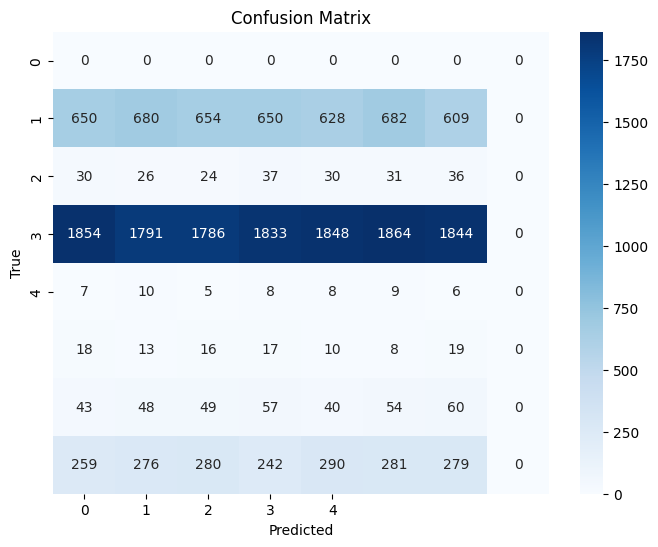

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Load Test Dataset (or use the validation set split from the previous code)
# Make sure to load the full dataset for evaluation
test_data = pd.read_csv('/content/Covid_Test_Data_20k.csv')

# Preprocess the test data
test_data = test_data.drop(columns = ['DATE_DIED'])  # Drop the DATE_DIED column
test_data = test_data.dropna()
X_test_full = test_data.drop(columns = ['CLASIFFICATION_FINAL'])  # Features
y_test_full = test_data['CLASIFFICATION_FINAL']  # True labels (severity from 0 to 4)

# Scale the features based on the scaler used during training
X_test_scaled = scaler.fit_transform(X_test_full)

# Evaluate Model
dqn_agent.model.eval()  # Set the model to evaluation mode

# Make predictions for the entire dataset
predictions = []
for i in range(len(X_test_scaled)):
    state = X_test_scaled[i]
    action = dqn_agent.choose_action(state)  # Predict severity level
    predictions.append(action)

# Accuracy
accuracy = accuracy_score(y_test_full, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# ROC-AUC Score
# Since it's a multi-class classification, we need to binarize the labels for ROC-AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_full)
predictions_binarized = lb.transform(predictions)

roc_auc = roc_auc_score(y_test_binarized, predictions_binarized, average = 'macro', multi_class = 'ovr')
print(f'ROC-AUC: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_full, predictions)

# Plotting the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = range(5), yticklabels = range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Load Dataset
data = pd.read_csv('/content/synthetic_heart_disease_data_corrected.csv')  # Replace with the correct file name

# Data Integration and Preprocessing
# data = data.drop(columns = ['DATE_DIED'])  # Drop the DATE_DIED column
# data = data.dropna()  # Remove missing values
X = data.drop(columns = ['num'])  # Features
y = data['num']  # Labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

print("Data pre-processing done")

# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(128, 64)
        # self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(64, output_dim)
        # self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent
class DQNAgent:
    def __init__(self, input_dim, output_dim, lr = 0.0001, gamma = 0.95, epsilon = 1.0, epsilon_decay = 0.9995, min_epsilon = 0.001):
        self.model = DQN(input_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, output_dim)
        state = torch.tensor(state, dtype = torch.float32)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def update(self, state, action, reward, next_state):
        state = torch.tensor(state, dtype = torch.float32)
        next_state = torch.tensor(next_state, dtype = torch.float32)
        q_values = self.model(state)
        next_q_values = self.model(next_state)

        target = q_values.clone().detach()
        target[action] = reward + self.gamma * torch.max(next_q_values).item()

        loss = self.criterion(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Training and Saving Model
output_dim = len(y.unique())  # Unique classification labels
model_path = 'dqn_healthcare_model.pth'
pickle_path = 'dqn_healthcare_model.pkl'

if not os.path.exists(model_path):
    dqn_agent = DQNAgent(X_train.shape[1], output_dim)
    for epoch in range(100):
        if(epoch % 10 == 0):
            print("Completed epoch = ", epoch)
        for i in tqdm(range(len(X_train))):
            state = X_train[i]
            action = dqn_agent.choose_action(state)
            reward = 1 if y_train.iloc[i] == action else -1
            next_state = X_train[(i + 1) % len(X_train)]
            dqn_agent.update(state, action, reward, next_state)
        dqn_agent.epsilon = max(dqn_agent.min_epsilon, dqn_agent.epsilon * dqn_agent.epsilon_decay)
    torch.save(dqn_agent.model.state_dict(), model_path)
    with open(pickle_path, 'wb') as f:
        pickle.dump(dqn_agent, f)
else:
    dqn_agent = DQNAgent(X_train.shape[1], output_dim)
    dqn_agent.model.load_state_dict(torch.load(model_path))

def evaluate_model(agent, X_test, y_test):
    correct = 0
    for i in range(len(X_test)):
        state = X_test[i]
        action = agent.choose_action(state)
        if action == y_test.iloc[i]:
            correct += 1
    accuracy = correct / len(X_test)
    print(f'Model Accuracy: {accuracy:.2f}')

evaluate_model(dqn_agent, X_test, y_test)
# Prediction Phase
# feature_names = X.columns.tolist()
# inputs = []
# print('Enter feature values one by one:')
# for feature in feature_names:
#     value = float(input(f'{feature}: '))
#     inputs.append(value)

# state = scaler.transform([inputs])[0]
# result = dqn_agent.choose_action(state)
# print(f'Prediction: Classification {result}')

Data pre-processing done
Model Accuracy: 0.23


<ipython-input-13-da227c2c1b2b>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent.model.load_state_dict(torch.load(model_path))


Accuracy: 18.26%
ROC-AUC: 0.4911


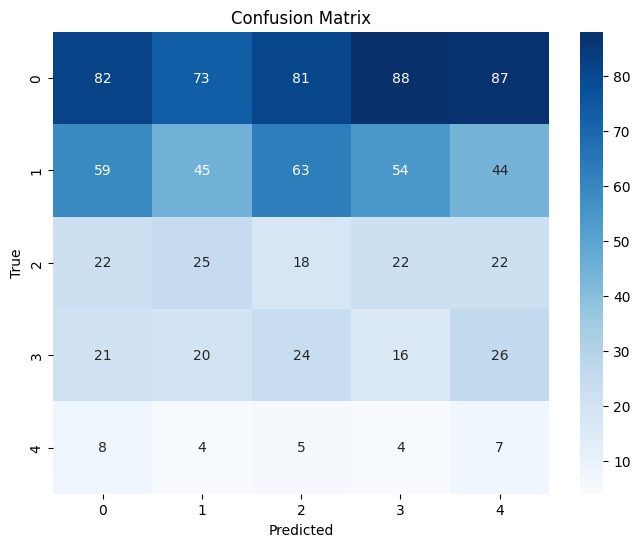

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Load Test Dataset (or use the validation set split from the previous code)
# Make sure to load the full dataset for evaluation
test_data = pd.read_csv('/content/merged_heart_disease_data.csv')

# Preprocess the test data
# test_data = test_data.drop(columns = ['DATE_DIED'])  # Drop the DATE_DIED column
# test_data = test_data.dropna()
X_test_full = test_data.drop(columns = ['num'])  # Features
y_test_full = test_data['num']  # True labels (severity from 0 to 4)

# Scale the features based on the scaler used during training
X_test_scaled = scaler.fit_transform(X_test_full)

# Evaluate Model
dqn_agent.model.eval()  # Set the model to evaluation mode

# Make predictions for the entire dataset
predictions = []
for i in range(len(X_test_scaled)):
    state = X_test_scaled[i]
    action = dqn_agent.choose_action(state)  # Predict severity level
    predictions.append(action)

# Accuracy
accuracy = accuracy_score(y_test_full, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# ROC-AUC Score
# Since it's a multi-class classification, we need to binarize the labels for ROC-AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_full)
predictions_binarized = lb.transform(predictions)

roc_auc = roc_auc_score(y_test_binarized, predictions_binarized, average = 'macro', multi_class = 'ovr')
print(f'ROC-AUC: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_full, predictions)

# Plotting the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = range(5), yticklabels = range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()